In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from openff.toolkit import Molecule
from qcelemental.models import Molecule, DriverEnum
from qcelemental.models.common_models import Model
from qcelemental.models.procedures import OptimizationSpecification, QCInputSpecification, TDKeywords, TorsionDriveInput
from qcengine import compute_procedure
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

In [2]:
import qcportal as ptl
import json
from collections import defaultdict

client = ptl.PortalClient("https://api.qcarchive.molssi.org/")
print(client)

PortalClient(server_name='The MolSSI OpenFF QCFractal Server', address='https://api.qcarchive.molssi.org/', username='None')


In [3]:
def plot_energy_contour(x, y, z, metadata, vmin, vmax, cmap='viridis'):
    import numpy as np
    import seaborn as sns
    from scipy.interpolate import griddata
    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 22
    # Assuming x, y, z are 1D arrays of the same length
    # Create a grid for x and y
    xi = np.linspace(x.min(), x.max(), 100)
    yi = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xi, yi)
    
    # Interpolate z values on the grid
    Z = griddata((x, y), z, (X, Y), method='cubic')
    print(Z.shape)
    min_Z = np.min(Z)
    Z = Z - min_Z
    
    # Create a contour plot
    plt.figure(figsize=(10, 8))
    contour_plot = plt.contourf(X, Y, Z, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add color bar
    cbar = plt.colorbar(contour_plot)
    cbar.set_label('Energy in kcal/mol', rotation=270)
    
    # Set the colorbar range
    plt.clim(vmin, vmax)
    # Add labels and title
    plt.title(metadata['title'])
    plt.xlabel(metadata['xlabel'])
    plt.ylabel(metadata['ylabel'])
    
    # Show plot
    plt.show()

def get_assigned_torsion_param(molecule, forcefield, central_bond_atoms):
    """
    for a molecule and specific dihedral check the assigned torsion parameter
    Parameters
    ----------
    molecule: openforcefield molecule object
    ff: ForceField offxml file
    central_bond_atoms: list of atom indices of central bond in the dihedral

    Returns
    -------
    parameter.id: str of the torsion parameter associated with the dihedral
    """
    if isinstance(forcefield, str):
        forcefield = ForceField(forcefield)
    topology = Topology.from_molecules([molecule])
    # Run the molecule labeling
    molecule_force_list = forcefield.label_molecules(topology)
    
    torsion_params = []
    # Print out a formatted description of the parameters applied to this molecule
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        for force_tag, force_dict in mol_forces.items():
            if force_tag == "ProperTorsions":
                for (atom_indices, parameter) in force_dict.items():
                    if (atom_indices[1], atom_indices[2]) == tuple(central_bond_atoms) or tuple(
                        reversed(atom_indices)
                    ) == tuple(central_bond_atoms):
                        print(parameter.smirks, atom_indices, parameter.id)
                        torsion_params.append([parameter.smirks, atom_indices, parameter.id])
    return torsion_params

def show_oemol_struc(oemol, torsions=False, atom_indices=[]):
    """
    Returns the oedepict image with or without the torsion highlighted

    Parameters
    ----------
    oemol: openeye oechem mol object
    torsions: boolean, to highlight dihedrals
    atom_indices: dihedral atom indices to highlight

    Returns
    -------
    Image: image in png format
    """
    from IPython.display import Image
    from openeye import oechem, oedepict

    width = 450
    height = 400

    # Highlight element of interest
    class NoAtom(oechem.OEUnaryAtomPred):
        def __call__(self, atom):
            return False

    class AtomInTorsion(oechem.OEUnaryAtomPred):
        def __call__(self, atom):
            return atom.GetIdx() in atom_indices

    class NoBond(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return False

    class BondInTorsion(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return (bond.GetBgn().GetIdx() in atom_indices) and (
                bond.GetEnd().GetIdx() in atom_indices
            )

    class CentralBondInTorsion(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return (bond.GetBgn().GetIdx() in atom_indices[1:3]) and (
                bond.GetEnd().GetIdx() in atom_indices[1:3]
            )

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
    oedepict.OEPrepareDepiction(oemol)
    img = oedepict.OEImage(width, height)
    display = oedepict.OE2DMolDisplay(oemol, opts)
    if torsions:
        atoms = oemol.GetAtoms(AtomInTorsion())
        bonds = oemol.GetBonds(NoBond())
        abset = oechem.OEAtomBondSet(atoms, bonds)
        oedepict.OEAddHighlighting(
            display,
            oechem.OEColor(oechem.OEYellow),
            oedepict.OEHighlightStyle_BallAndStick,
            abset,
        )

    oedepict.OERenderMolecule(img, display)
    png = oedepict.OEWriteImageToString("png", img)
    return Image(png)

def return_td_result(ff_name, qcmol, dihedral_metadata):
    result = compute_procedure(
    input_data=TorsionDriveInput(
        keywords=dihedral_metadata,
        input_specification=QCInputSpecification(
            driver=DriverEnum.gradient,
            model=Model(method=ff_name, basis='smirnoff')
        ),
        initial_molecule=[qcmol,],
        optimization_spec=OptimizationSpecification(
            procedure="geomeTRIC",
            keywords={
                "coordsys": "dlc",
                "maxiter": 300,
                "program": "openmm",
            }
        )
    ),
    procedure="torsiondrive"
)
    energies = list(result.final_energies.values())
    min_ener = min(energies)
    energies = [(it-min_ener) * 627.5094740630558 for it in energies]
    angles = list(result.final_energies.keys())
    # angles = [int(it) for it in angles]
    # angles, energies = zip(*sorted(zip(angles, energies)))
    return result, angles, energies

In [4]:
ds = client.get_dataset("TorsionDrive", "OpenFF Aniline 2D Impropers v1.0")
specifications = ["default"]  

In [5]:
ds.status()

{'default': {<RecordStatusEnum.complete: 'complete'>: 12,
  <RecordStatusEnum.error: 'error'>: 12}}

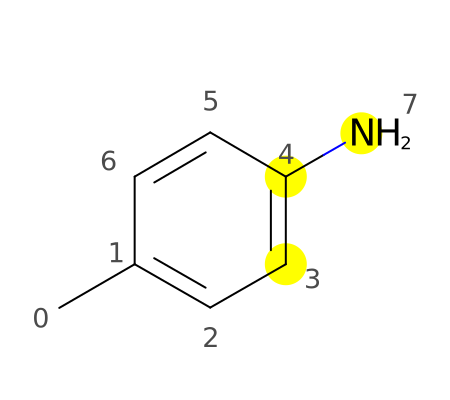

0.0
(100, 100)


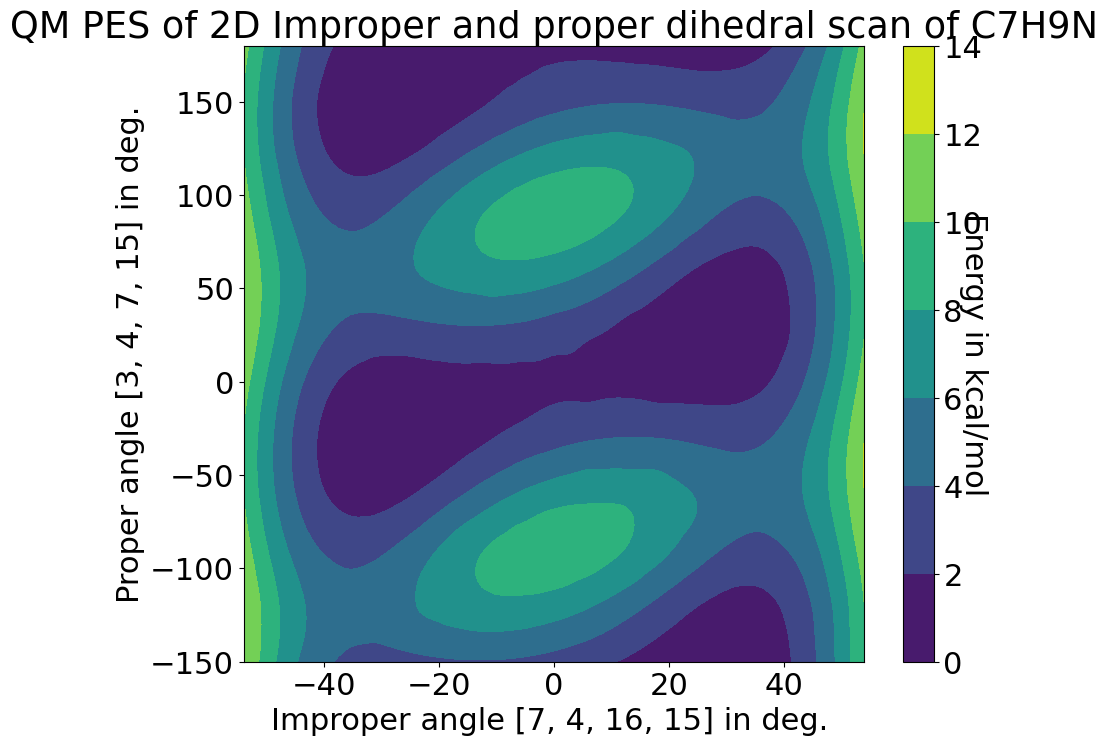

In [6]:
for entry_name in ds.entry_names:
    entry = ds.get_entry(entry_name)
    rec = ds.get_record(entry_name=entry_name, specification_name='default')
    if rec.status == 'complete':
        mol = Molecule.from_mapped_smiles(entry.attributes['canonical_isomeric_explicit_hydrogen_mapped_smiles'])
        display(show_oemol_struc(mol.to_openeye(), torsions=True, atom_indices=[3, 7, 4, 16, 15]))
        x = []
        y = []
        z = []
        for key, value in rec.final_energies.items():
            x.append(key[0])
            y.append(key[1])
            z.append(value)
        
        x = np.array(x)
        y = np.array(y)
        z = np.array(z) * 627.509
        min_z = min(z)
        z = z - min_z
        print(min(z))
        metadata = {}
        if rec.status == 'error':
            metadata['title'] = f'(Partial data) 2D Improper scan of {entry.attributes["molecular_formula"]}'
        else:
            metadata['title'] = f'QM PES of 2D Improper and proper dihedral scan of {entry.attributes["molecular_formula"]}'
        metadata['xlabel'] = f'Improper angle {entry.additional_keywords["dihedrals"][0]} in deg. '
        metadata['ylabel'] = f'Proper angle {entry.additional_keywords["dihedrals"][1]} in deg.'
        plot_energy_contour(x,y,z, metadata, vmin=0, vmax=14)
        break

In [7]:
qcmol = rec.initial_molecules[0]

In [8]:
entry.additional_keywords

{'dihedrals': [[7, 4, 16, 15], [3, 4, 7, 15]],
 'grid_spacing': [6, 30],
 'dihedral_ranges': [[-54, 54], [-150, 180]],
 'energy_upper_limit': 0.05,
 'energy_decrease_thresh': None}

In [9]:

import logging
from collections.abc import Generator
from multiprocessing import Pool

from numpy.typing import NDArray
from pydantic import Field
from tqdm import tqdm

from yammbs._base.array import Array
from yammbs._base.base import ImmutableModel
from yammbs._minimize import _lazy_load_force_field

LOGGER = logging.getLogger(__name__)


class ConstrainedMinimizationInput(ImmutableModel):
    # This is more like a "TorsionDrive" ID than a molecule ID,
    # but it's how the database is currently structured.
    molecule_id: int = Field(
        ...,
        description="The identifier of the molecule",
    )
    mapped_smiles: str = Field(
        ...,
        description="The SMILES of the molecule",
    )
    dihedral_indices: tuple[int, int, int, int] = Field(
        ...,
        description="The indices of the atoms which define the driven dihedral angle",
    )
    force_field: str = Field(
        ...,
        description="And identifier of the force field to use for the minimization",
    )
    coordinates: Array = Field(
        ...,
        description="The coordinates [Angstrom] of this conformer with shape=(n_atoms, 3).",
    )
    grid_id: float = Field(
        ...,
        description="The grid identifier of the torsion scan point.",
    )


class ConstrainedMinimizationResult(ConstrainedMinimizationInput):
    energy: float = Field(
        ...,
        description="Minimized energy in kcal/mol",
    )


def _minimize_torsions(
    data: Generator[
        tuple[
            int,
            str,
            tuple[int, int, int, int],
            float,
            NDArray,
            float,
        ],
        None,
        None,
    ],
    force_field: str,
    n_processes: int = 2,
    chunksize=32,
) -> Generator[ConstrainedMinimizationResult, None, None]:
    LOGGER.info("Mapping `data` generator into `inputs` generator")

    # It'd be smoother to skip this tranformation - just pass this generator
    # from inside of TorsionStore
    inputs: Generator[ConstrainedMinimizationInput, None, None] = (
        ConstrainedMinimizationInput(
            molecule_id=molecule_id,
            mapped_smiles=mapped_smiles,
            dihedral_indices=dihedral_indices,
            force_field=force_field,
            coordinates=coordinates,
            grid_id=grid_id,
        )
        for (molecule_id, mapped_smiles, dihedral_indices, grid_id, coordinates, _) in data
    )

    LOGGER.info("Setting up multiprocessing pool with generator (of unknown length)")

    # TODO: It'd be nice to have the `total` argument passed through, but that would require using
    #       a list-like iterable instead of a generator, which might cause problems at scale
    with Pool(processes=n_processes) as pool:
        for val in tqdm(
            pool.imap(
                _minimize_constrained,
                inputs,
                chunksize=chunksize,
            ),
            desc=f"Building and minimizing systems with {force_field}",
        ):
            if val is not None:
                yield val


class ConstrainedMinimizationError(Exception):
    """The constrained minimization failed."""

    pass


def _minimize_constrained(
    input: ConstrainedMinimizationInput,
) -> ConstrainedMinimizationResult:
    """Taken from openff-strike-team 10/31/24.

    https://github.com/lilyminium/openff-strike-team/blob/a6ccd2821ed627064529f5c4a22b47c1fa36efe2/torsions/datasets/mm/minimize-torsion-constrained.py#L35-L106
    """
    import openmm
    import openmm.unit
    from openff.interchange.operations.minimize import _DEFAULT_ENERGY_MINIMIZATION_TOLERANCE
    from openff.toolkit import Molecule, Quantity

    LOGGER.debug(f"Setting up constrained minimization for {input.dict()=}")

    # TODO: Pass this through
    restrain_k = 1.0

    # TODO: GAFF/Espaloma/local file/plugin force fields

    LOGGER.debug(f"Loading force field {input.force_field=}")
    force_field = _lazy_load_force_field(input.force_field)

    # if this force field is constrained, this will be the H-* constraint ...
    try:
        assert "tip3p" not in force_field["Constraints"].parameters[0].id
    except (KeyError, AssertionError):
        pass

    LOGGER.debug(f"Creating molecule, with conformer, from {input.mapped_smiles=}")
    molecule = Molecule.from_mapped_smiles(input.mapped_smiles, allow_undefined_stereo=True)
    molecule.add_conformer(Quantity(input.coordinates, "angstrom"))

    LOGGER.debug("Creating interchange object")
    interchange = force_field.create_interchange(molecule.to_topology())

    restraint_force = openmm.CustomExternalForce("0.5*k*((x-x0)^2+(y-y0)^2+(z-z0)^2)")
    restraint_force.addGlobalParameter(
        "k",
        restrain_k * openmm.unit.kilocalorie_per_mole / openmm.unit.angstrom**2,
    )
    for parameter in ("x0", "y0", "z0"):
        restraint_force.addPerParticleParameter(parameter)

    atom_indices = list(range(len(molecule.atoms)))
    atom_indices = sorted(set(atom_indices))  # - set([index - 0 for index in input.dihedral_indices]))

    # switch to nm now... just in case
    positions = interchange.positions.to("nanometer")

    LOGGER.debug(f"Adding restraint to particles not in {input.dihedral_indices=}")
    for atom_index in range(molecule.n_atoms):
        if atom_index in input.dihedral_indices:
            continue

        particle_index = restraint_force.addParticle(atom_index)
        restraint_force.setParticleParameters(
            particle_index,
            atom_index,
            [x.to_openmm() for x in positions[atom_index]],
        )

    LOGGER.debug("Creating openmm.app.Simulation object")
    simulation = interchange.to_openmm_simulation(
        openmm.LangevinMiddleIntegrator(
            293.15 * openmm.unit.kelvin,
            1.0 / openmm.unit.picosecond,
            2.0 * openmm.unit.femtosecond,
        ),
        combine_nonbonded_forces=True,
        additional_forces=[restraint_force],
    )

    simulation.context.computeVirtualSites()

    for index in input.dihedral_indices:
        simulation.system.setParticleMass(index, 0.0)

    LOGGER.debug("Trying to minimize energy")
    try:
        simulation.minimizeEnergy(
            tolerance=_DEFAULT_ENERGY_MINIMIZATION_TOLERANCE.to_openmm(),
            maxIterations=10_000,
        )
    except Exception as e:
        LOGGER.error(
            {
                index: simulation.system.getParticleMass(index)._value
                for index in range(simulation.system.getNumParticles())
            },
        )
        LOGGER.error(input.dihedral_indices, input.mapped_smiles)

        raise ConstrainedMinimizationError("Minimization failed, see logger") from e

    LOGGER.debug("Returning result")
    return ConstrainedMinimizationResult(
        molecule_id=input.molecule_id,
        mapped_smiles=input.mapped_smiles,
        dihedral_indices=input.dihedral_indices,
        force_field=input.force_field,
        coordinates=simulation.context.getState(getPositions=True)
        .getPositions(asNumpy=True)
        .value_in_unit(openmm.unit.angstrom)[: interchange.positions.shape[0], :],
        energy=simulation.context.getState(
            getEnergy=True,
        )
        .getPotentialEnergy()
        .value_in_unit(
            openmm.unit.kilocalorie_per_mole,
        ),
        grid_id=input.grid_id,
    )


KeyError: "Cannot find a registered parameter handler class for tag 'HarmonicHeight'\nKnown parameter handler class tags are dict_keys(['Constraints', 'Bonds', 'Angles', 'ProperTorsions', 'ImproperTorsions', 'GBSA', 'vdW', 'Electrostatics', 'LibraryCharges', 'ToolkitAM1BCC', 'ChargeIncrementModel', 'VirtualSites'])"

In [ ]:
x = []
y = []
z = []
for i,j in zip(angles,energies):
    ang = i.split(',')
    x.append(int(ang[0]))
    y.append(int(ang[1]))
    z.append(j)

entry = ds.get_entry(entry_name)
rec = ds.get_record(entry_name=entry_name, specification_name='default')
mol = Molecule.from_mapped_smiles(entry.attributes['canonical_isomeric_explicit_hydrogen_mapped_smiles'])
display(mol.visualize(backend='openeye'))

x = np.array(x)
y = np.array(y)
z = np.array(z)
metadata = {}
if rec.status == 'error':
    metadata['title'] = f'(Partial data) 2D Improper scan of {entry.attributes['molecular_formula']}'
else:
    metadata['title'] = f'MM PES of 2D Improper and proper dihedral scan of {entry.attributes['molecular_formula']}'
metadata['xlabel'] = f'Improper angle {entry.additional_keywords['dihedrals'][0]} in deg.'
metadata['ylabel'] = f'Proper angle {entry.additional_keywords['dihedrals'][1]} in deg.'
plot_energy_contour(x,y,z, metadata, vmin=0, vmax=14)


In [ ]:
with open('improper_and_proper_2D_scan_MM.json', 'w') as output:
    output.write(result.json())